In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from joblib import Parallel, delayed

# Part 1: Bernouilli Bandits

### Follow the Leader

In [2]:
class BernouilliBandits:
    def __init__(self, pk) -> None:
        self.pk = pk
    
    def pull_arm(self, action) -> int:
        return int(np.random.rand() < self.pk[action])
    
    def compute_regret(self, actions) -> int:
        T = len(actions)
        return T * np.max(self.pk) - np.sum([self.pk[a] for a in actions.astype(int)])

In [3]:
class FollowTheLeader:
    def __init__(self, k) -> None:
        self.estimates = - np.ones(k)
        self.nb_try = np.zeros_like(self.estimates)
        self.length = k
    
    def update(self, action, reward) -> None:
        if self.nb_try[action] == 0:
            self.estimates[action] = reward
            self.nb_try[action] += 1
        else:
            self.estimates[action] = (self.nb_try[action] * self.estimates[action] + reward) / (self.nb_try[action] + 1)
            self.nb_try[action] += 1
        
    def play(self) -> int:
        tried_it_all = (np.sum(self.nb_try == 0) == 0)
        if tried_it_all:
            probas = (self.estimates == np.max(self.estimates))
            return np.random.choice(self.length, p=probas/np.sum(probas))
        else:
            probas = (self.estimates == -1).astype(int)
            return np.random.choice(self.length, p=probas/np.sum(probas))

In [4]:
def run_FTL(pk, T=100) -> tuple:
    
    bandits = BernouilliBandits(pk)
    ftl = FollowTheLeader(len(pk))

    actions = np.zeros(T)
    rewards = np.zeros(T)
    for t in range(T):
        action = ftl.play()
        reward = bandits.pull_arm(action)
        ftl.update(action, reward)
        actions[t] = action
        rewards[t] = reward
    
    regret = bandits.compute_regret(actions)
    return actions, rewards, regret

def experiment_FTL(pk, T):
    bandits = BernouilliBandits(pk)
    regrets = np.zeros((T - 1))
    actions, _, _ = run_FTL(pk, T=T)
    for t in range(1, T):
        regrets[t - 1] = bandits.compute_regret(actions[:t])
    return regrets

pk: [0.5 0.6]


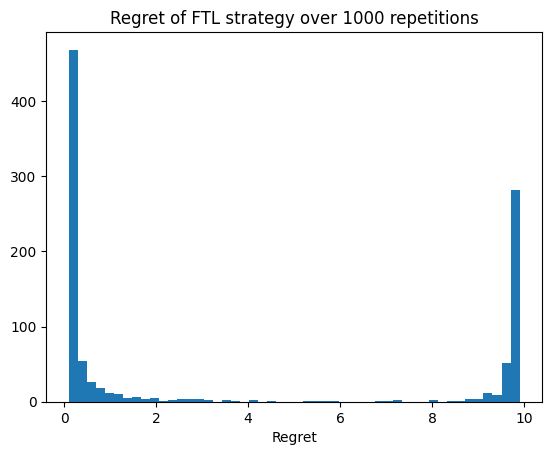

In [5]:
pk = np.array([0.5, 0.6])
print('pk:', pk)

nb_repet = 1_000
regrets = np.zeros(nb_repet)
for repet in range(nb_repet):
    _, _, regret = run_FTL(pk)
    regrets[repet] = regret

plt.hist(regrets, bins=50)
plt.title('Regret of FTL strategy over 1000 repetitions')
plt.xlabel("Regret")
plt.show()

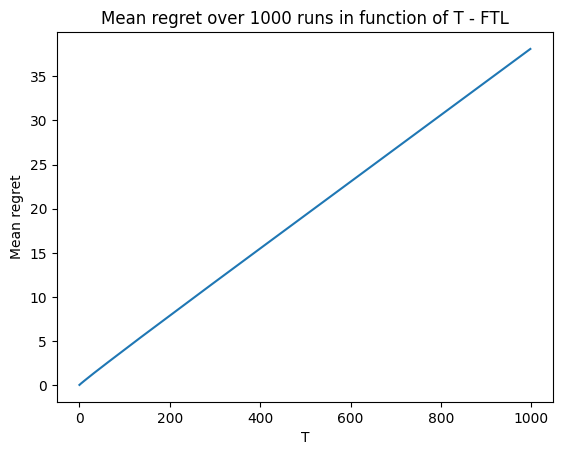

In [6]:
# Number of runs
num_runs = 1000

# Parallel execution of the experiment
results = Parallel(n_jobs=-1)(delayed(experiment_FTL)(pk=np.array([0.5, 0.6]), T=1000) for _ in range(num_runs))

mean_regrets_ftl = np.mean(np.stack(results), axis=0)

plt.plot(mean_regrets_ftl)
plt.title("Mean regret over 1000 runs in function of T - FTL")
plt.xlabel("T")
plt.ylabel("Mean regret")
plt.show()


### UCB

In [7]:
class UpperConfidenceBound:
    def __init__(self, k, sigma=1/4, xsi=1.1) -> None:
        self.estimates = - np.ones(k)
        self.nb_try = np.zeros_like(self.estimates)
        self.length = k
        self.xsi = xsi
        self.sigma = sigma
        self.time = 0
    
    def update(self, action, reward) -> None:
        self.time += 1
        if self.nb_try[action] == 0:
            self.estimates[action] = reward
            self.nb_try[action] += 1
        else:
            self.estimates[action] = (self.nb_try[action] * self.estimates[action] + reward) / (self.nb_try[action] + 1)
            self.nb_try[action] += 1
            
    def compute_estimate_bound(self) -> np.array:
        bound = np.where(self.nb_try >= 0,
                 np.sqrt(2 * (self.sigma) * self.xsi * np.log(self.time) / self.nb_try),
                 0)
        return self.estimates + bound
        
    def play(self) -> int:
        tried_it_all = (np.sum(self.nb_try == 0) == 0)
        if tried_it_all:
            estimate_bound = self.compute_estimate_bound()
            probas = (estimate_bound == np.max(estimate_bound))
            return np.random.choice(self.length, p=probas/np.sum(probas))
        else:
            probas = (self.estimates == -1).astype(int)
            return np.random.choice(self.length, p=probas/np.sum(probas))

In [8]:
def run_UCB(pk, sigma=1/4, T=1000) -> tuple:
    
    bandits = BernouilliBandits(pk)
    ucb = UpperConfidenceBound(len(pk), sigma=sigma)

    actions = np.zeros(T)
    rewards = np.zeros(T)
    for t in range(T):
        action = ucb.play()
        reward = bandits.pull_arm(action)
        ucb.update(action, reward)
        actions[t] = action
        rewards[t] = reward
    
    regret = bandits.compute_regret(actions)
    return actions, rewards, regret

def experiment_UCB(pk, T, sigma=1/4):
    bandits = BernouilliBandits(pk)
    regrets = np.zeros((T - 1))
    actions, _, _ = run_UCB(pk, sigma=sigma, T=T)
    for t in range(1, T):
        regrets[t - 1] = bandits.compute_regret(actions[:t])
    return regrets

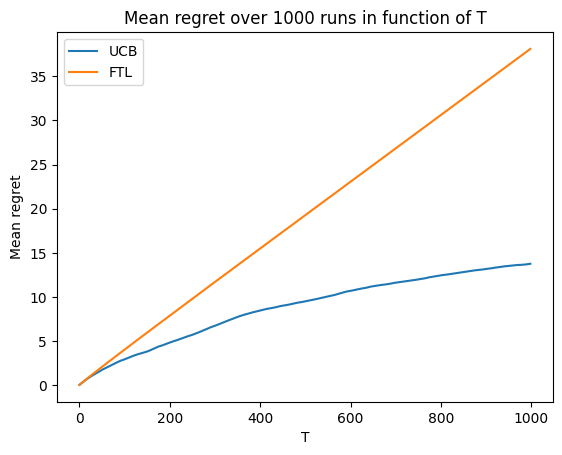

In [9]:
# Number of runs
num_runs = 100

# Parallel execution of the experiment
results = Parallel(n_jobs=-1)(delayed(experiment_UCB)(pk=np.array([0.5, 0.6]), T=1000) for _ in range(num_runs))

mean_regrets_ucb = np.mean(np.stack(results), axis=0)

plt.plot(mean_regrets_ucb, label='UCB')
plt.plot(mean_regrets_ftl, label='FTL')
plt.title("Mean regret over 1000 runs in function of T")
plt.xlabel("T")
plt.ylabel("Mean regret")
plt.legend()
plt.show()


100%|██████████| 5/5 [00:48<00:00,  9.70s/it]


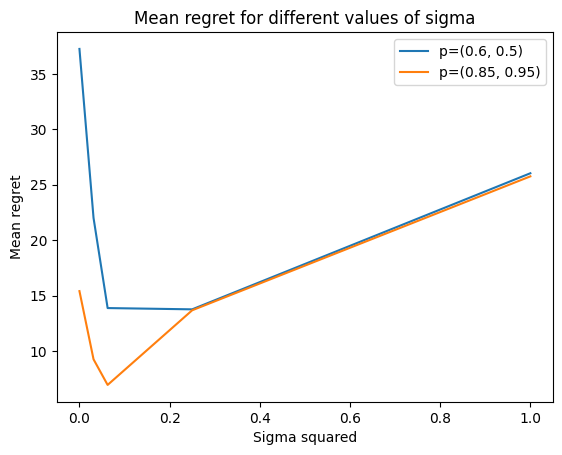

In [10]:
p1, p2 = 0.5, 0.6
nb_repet = 1000
list_sigmas = [0, 1/32, 1/16, 1/4, 1]

def sigma_experiment_UCB(pk, T, sigma):
    _, _, regret = run_UCB(pk, sigma=sigma, T=T)
    return regret

mean_results1 = np.zeros(len(list_sigmas))
for i, sigma in enumerate(tqdm(list_sigmas)):
    results = Parallel(n_jobs=-1)(delayed(sigma_experiment_UCB)(pk=np.array([p1, p2]), T=1000, sigma=sigma) for _ in range(nb_repet))
    mean_results1[i] = np.mean(results)
    
p1, p2 = 0.85, 0.95
mean_results2 = np.zeros(len(list_sigmas))
for i, sigma in enumerate(tqdm(list_sigmas)):
    results = Parallel(n_jobs=-1)(delayed(sigma_experiment_UCB)(pk=np.array([p1, p2]), T=1000, sigma=sigma) for _ in range(nb_repet))
    mean_results2[i] = np.mean(results)



plt.plot(list_sigmas, mean_results1, label="p=(0.6, 0.5)")
plt.plot(list_sigmas, mean_results2, label="p=(0.85, 0.95)")
plt.title("Mean regret for different values of sigma")
plt.xlabel("Sigma squared")
plt.ylabel("Mean regret")
plt.legend()
plt.show()


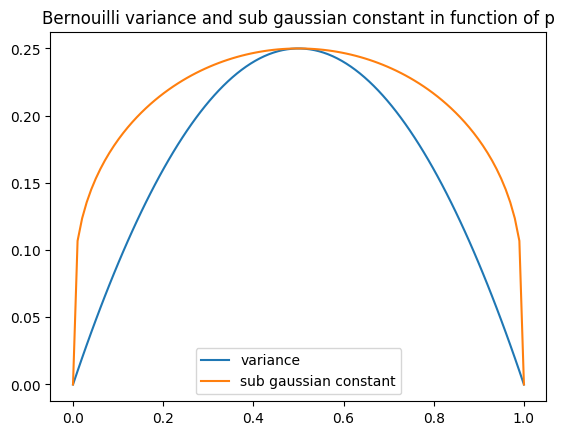

In [11]:

p = np.linspace(0, 1, 100)
variance = p * (1 - p)
sub_gaussian = np.zeros(len(variance))
sub_gaussian[1:-1] = np.where((p[1:-1] == 0.5), 0.25, 0.5 * (p[1:-1] - (1 - p[1:-1])) / (np.log(p[1:-1]) - np.log(1 - p[1:-1])))

plt.plot(p, variance, label='variance')
plt.plot(p, sub_gaussian, label='sub gaussian constant')
plt.title("Bernouilli variance and sub gaussian constant in function of p")
plt.legend()
plt.show()

### UCB-V

In [12]:
class UpperConfidenceBoundVariance:
    def __init__(self, k, xsi=1.1, c=1) -> None:
        self.mu_estimates = - np.ones(k)
        self.buffer = [[] for _ in range(k)]
        self.nb_try = np.zeros_like(self.mu_estimates)
        self.length = k
        self.xsi = xsi
        self.c = c
        self.time = 0
    
    def update(self, action, reward) -> None:
        self.time += 1
        if self.nb_try[action] == 0:
            self.mu_estimates[action] = reward
        else:
            self.mu_estimates[action] = (self.nb_try[action] * self.mu_estimates[action] + reward) / (self.nb_try[action] + 1)
        self.buffer[action].append(reward)
        self.nb_try[action] += 1
    
    def compute_var_estimate(self) -> np.array:
        var_estimate = np.zeros(self.length)
        for i in range(self.length):
            if self.nb_try[i] == 0:
                var_estimate = 0
            else:
                var_estimate = np.sum((np.array(self.buffer[i]) - self.mu_estimates[i])**2) / self.nb_try[i]
        return var_estimate
    
    def compute_estimate_bound(self) -> np.array:
        bound1 = np.where(self.nb_try >= 0,
                 np.sqrt(2 * (self.compute_var_estimate()) * self.xsi * np.log(self.time) / self.nb_try),
                 0)
        bound2 = np.where(self.nb_try >= 0,
                 (3 * self.c * self.xsi) / self.nb_try,
                 0)
        return self.mu_estimates + bound1 + bound2
        
    def play(self) -> int:
        tried_it_all = (np.sum(self.nb_try == 0) == 0)
        if tried_it_all:
            estimate_bound = self.compute_estimate_bound()
            probas = (estimate_bound == np.max(estimate_bound))
            return np.random.choice(self.length, p=probas/np.sum(probas))
        else:
            probas = (self.mu_estimates == -1).astype(int)
            return np.random.choice(self.length, p=probas/np.sum(probas))

In [13]:
def run_UCBV(pk, T=1000) -> tuple:
    
    bandits = BernouilliBandits(pk)
    ucbv = UpperConfidenceBoundVariance(len(pk))

    actions = np.zeros(T)
    rewards = np.zeros(T)
    for t in range(T):
        action = ucbv.play()
        reward = bandits.pull_arm(action)
        ucbv.update(action, reward)
        actions[t] = action
        rewards[t] = reward
    
    regret = bandits.compute_regret(actions)
    return actions, rewards, regret

def experiment_UCBV(pk, T):
    bandits = BernouilliBandits(pk)
    regrets = np.zeros((T - 1))
    actions, _, _ = run_UCBV(pk, T=T)
    for t in range(1, T):
        regrets[t - 1] = bandits.compute_regret(actions[:t])
    return regrets

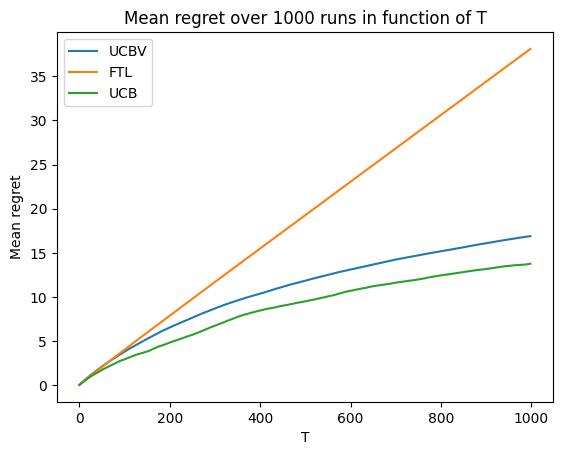

In [14]:
num_runs = 1000

# Parallel execution of the experiment
results = Parallel(n_jobs=-1)(delayed(experiment_UCBV)(pk=np.array([0.5, 0.6]), T=1000) for _ in range(num_runs))

mean_regrets_ucbv = np.mean(np.stack(results), axis=0)

plt.plot(mean_regrets_ucbv, label='UCBV')
plt.plot(mean_regrets_ftl, label='FTL')
plt.plot(mean_regrets_ucb, label='UCB')
plt.title("Mean regret over 1000 runs in function of T")
plt.xlabel("T")
plt.ylabel("Mean regret")
plt.legend()
plt.show()

In [15]:
class ThompsonSampling:
    def __init__(self, k) -> None:
        self.nb_try = np.zeros(k)
        self.sum_reward = np.zeros(k)
        self.length = k
    
    def update(self, action, reward) -> None:
        self.nb_try[action] += 1
        self.sum_reward[action] += reward
        
    def get_prior_parameters(self, i) -> tuple:
        return (self.sum_reward[i] + 1, self.nb_try[i] - self.sum_reward[i] + 1)
    
    def sample_prior(self) -> np.array:
        return np.array([np.random.beta(*self.get_prior_parameters(i)) for i in range(self.length)])
        
    def play(self) -> int:
        samples = self.sample_prior()
        return np.argmax(samples)

In [16]:
def run_ThompsonSampling(pk, T=1000) -> tuple:
    
    bandits = BernouilliBandits(pk)
    thom_sampl = ThompsonSampling(len(pk))

    actions = np.zeros(T)
    rewards = np.zeros(T)
    for t in range(T):
        action = thom_sampl.play()
        reward = bandits.pull_arm(action)
        thom_sampl.update(action, reward)
        actions[t] = action
        rewards[t] = reward
    
    regret = bandits.compute_regret(actions)
    return actions, rewards, regret

def experiment_ThompsonSampling(pk, T):
    bandits = BernouilliBandits(pk)
    regrets = np.zeros((T - 1))
    actions, _, _ = run_ThompsonSampling(pk, T=T)
    for t in range(1, T):
        regrets[t - 1] = bandits.compute_regret(actions[:t])
    return regrets

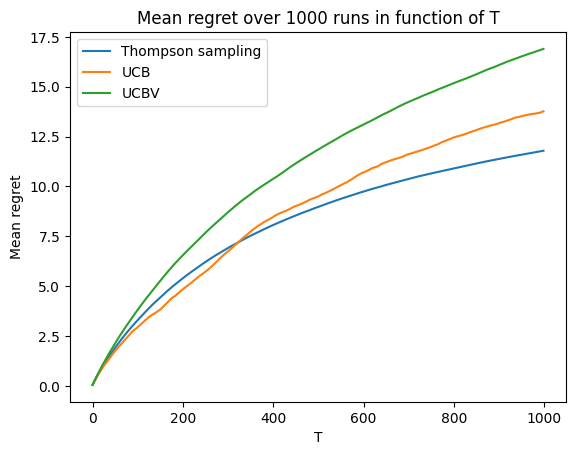

In [17]:
num_runs = 1000

# Parallel execution of the experiment
results = Parallel(n_jobs=-1)(delayed(experiment_ThompsonSampling)(pk=np.array([0.5, 0.6]), T=1000) for _ in range(num_runs))

mean_regrets_ts = np.mean(np.stack(results), axis=0)

plt.plot(mean_regrets_ts, label='Thompson sampling')
plt.plot(mean_regrets_ucb, label='UCB')
plt.plot(mean_regrets_ucbv, label='UCBV')

plt.title("Mean regret over 1000 runs in function of T")
plt.xlabel("T")
plt.ylabel("Mean regret")
plt.legend()
plt.show()

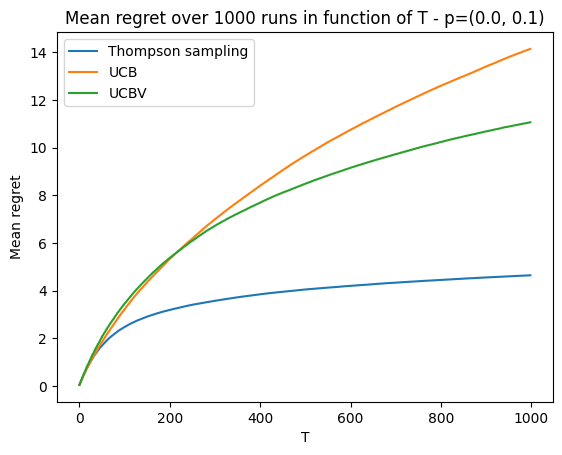

In [18]:
num_runs = 1000
p1, p2 = 0.0, 0.1

# Parallel execution of the experiment
results = Parallel(n_jobs=-1)(delayed(experiment_UCB)(pk=np.array([p1, p2]), T=1000) for _ in range(num_runs))
mean_regrets_ucb = np.mean(np.stack(results), axis=0)

results = Parallel(n_jobs=-1)(delayed(experiment_UCBV)(pk=np.array([p1, p2]), T=1000) for _ in range(num_runs))
mean_regrets_ucbv = np.mean(np.stack(results), axis=0)

results = Parallel(n_jobs=-1)(delayed(experiment_ThompsonSampling)(pk=np.array([p1, p2]), T=1000) for _ in range(num_runs))
mean_regrets_ts = np.mean(np.stack(results), axis=0)

plt.plot(mean_regrets_ts, label='Thompson sampling')
plt.plot(mean_regrets_ucb, label='UCB')
plt.plot(mean_regrets_ucbv, label='UCBV')

plt.title(f"Mean regret over 1000 runs in function of T - p=({p1}, {p2})")
plt.xlabel("T")
plt.ylabel("Mean regret")
plt.legend()
plt.show()

# Part 2: Rock, Paper, Scissors

### Full information feedback

In [19]:
loss_matrix = np.array([[0.0, 1.0, -1.0],
                        [-1.0, 0.0, 1.0],
                        [1.0, -1.0, 0.0]])


store_q = []
store_p = []

def EWA_update(eta, pt, lt):
    return pt * np.exp(-eta * lt) / np.sum(pt * np.exp(-eta * lt))

def best_play(pt, L):
    value = np.transpose(pt) @ L
    idx_max = np.argmax(value)
    if value[0] == value[1] and value[1] == value[2]:
        return np.ones_like(pt) / 3
    if (value[0] == value[1]) and (value[0] == value[idx_max]):
        return np.array([1, 1, 0]) / 2
    if (value[1] == value[2]) and (value[1] == value[idx_max]):
        return np.array([0, 1, 1]) / 2
    if (value[0] == value[2]) and (value[0] == value[idx_max]):
        return np.array([1, 0, 1]) / 2
    q = np.zeros_like(pt)
    q[idx_max] = 1
    return q


def run_EWA(eta, T, loss_matrix, p0=np.array([1/3, 1/3, 1/3])):
    ps = np.zeros((T, p0.shape[0]))
    losses = np.zeros(T)

    for t in range(0, T):
        ps[t, :] = p0[:]
        action_p = np.random.choice([0, 1, 2], p=p0)
        action_q = np.random.choice([0, 1, 2], p=best_play(p0, loss_matrix))
        store_q.append(action_q)
        store_p.append(action_p)
        losses[t] = loss_matrix[action_p, action_q]
        p0 = EWA_update(eta, p0, -loss_matrix[action_q, :])
        
    print('Final p0:', p0)
    return ps, losses

Final p0: [0.49733088 0.13518855 0.36748057]


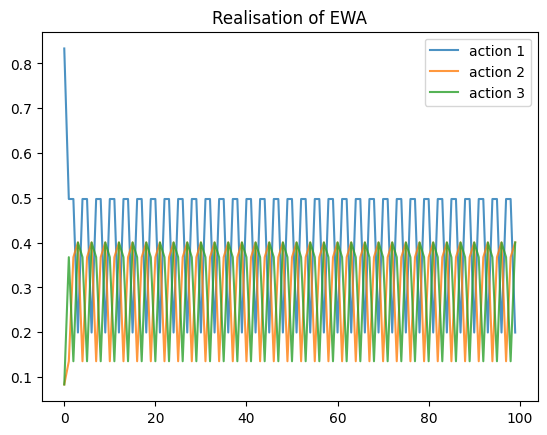

In [20]:
T = 100
eta = 1
p0 = np.array([1.0, 0.1, 0.1]) #np.random.random(3)
p0 = p0 / np.sum(p0)
ps, _ = run_EWA(eta, T, loss_matrix, p0=p0)

plt.plot(ps, label=['action 1', 'action 2', 'action 3'], alpha=0.8)
plt.legend()
plt.title('Realisation of EWA')
plt.show()

Final p0: [0.49733088 0.13518855 0.36748057]


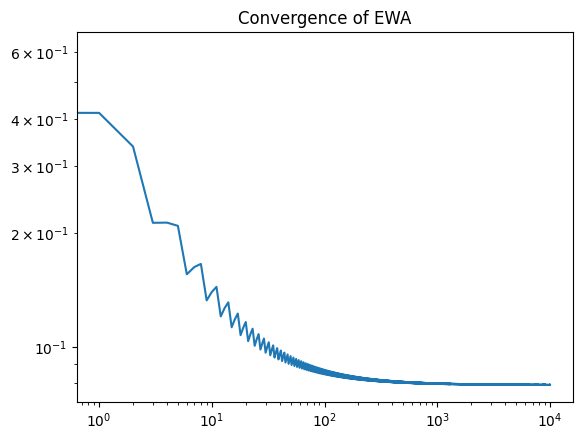

In [21]:
ps, losses = run_EWA(eta, 10000, loss_matrix, p0=p0)


p_ = np.array([np.mean(ps[:i, :], axis=0) for i in range(1, ps.shape[0])])

plt.loglog(np.array([np.linalg.norm(p - np.array([1/3, 1/3, 1/3])) for p in p_]))
plt.title('Convergence of EWA')
plt.show()

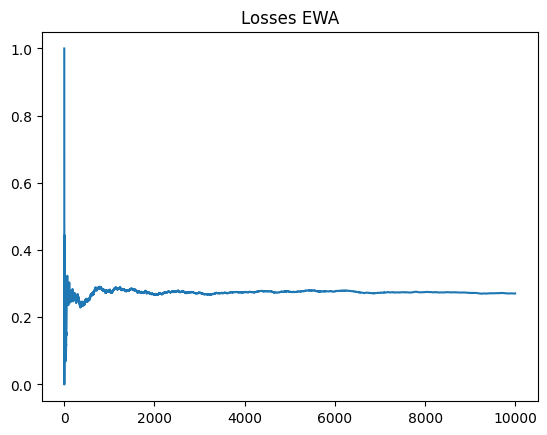

In [22]:
losses_ = np.array([np.mean(losses[:i]) for i in range(1, losses.shape[0])])

plt.plot(losses_)
plt.title('Losses EWA')
plt.show()

Final p0: [0.33501825 0.33082843 0.33415332]
Final p0: [0.32830208 0.32745448 0.34424344]
Final p0: [0.34483715 0.31121599 0.34394686]
Final p0: [0.33816286 0.24987044 0.4119667 ]
Final p0: [0.49733088 0.13518855 0.36748057]


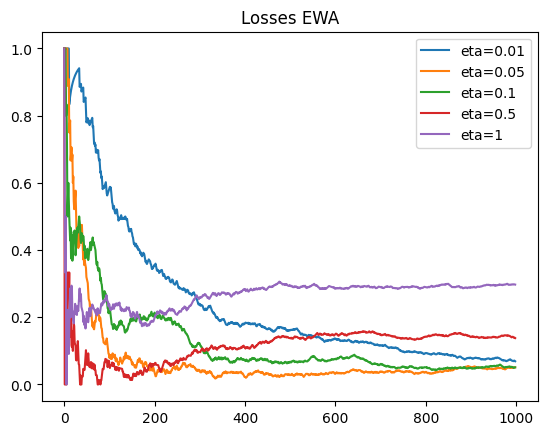

In [23]:
T = 1000
for eta in [0.01, 0.05, 0.1, 0.5, 1]:
    ps, losses = run_EWA(eta, T, loss_matrix, p0=p0)
    losses_ = np.array([np.mean(losses[:i]) for i in range(1, losses.shape[0])])

    plt.plot(losses_, label='eta=' + str(eta))
plt.title('Losses EWA')
plt.legend()
plt.show()



### Bandit FeedBack

In [24]:
class EXP3:
    def __init__(self, eta, p0=np.array([1/3, 1/3, 1/3])) -> None:
        self.eta = eta
        self.p = p0
        self.estimates = np.zeros_like(p0)
    
    def update(self, action, loss) -> None:
        # update estimates
        self.estimates[action] += loss / self.p[action]
        # update probabilities
        self.p = np.exp(- self.eta * self.estimates) / np.sum(np.exp(- self.eta * self.estimates))
    
    def play(self) -> int:
        return np.random.choice([0, 1, 2], p=self.p)

In [25]:
p01 = np.random.random(3)
p01 = p01 / np.sum(p01)
p02 = np.random.random(3)
p02 = p02 / np.sum(p02)

player1 = EXP3(eta=0.01, p0=p01)
player2 = EXP3(eta=0.01, p0=p02)

store1 = []
store2 = []
ps = []
losses = []

for t in range(1000):
    ps.append(player1.p)
    action1 = player1.play()
    action2 = player2.play()
    store1.append(action1)
    store2.append(action2)
    loss = loss_matrix[action1, action2]
    losses.append(loss)
    player1.update(action1, loss)
    player2.update(action2, -loss)

losses = np.array(losses)
ps = np.array(ps)

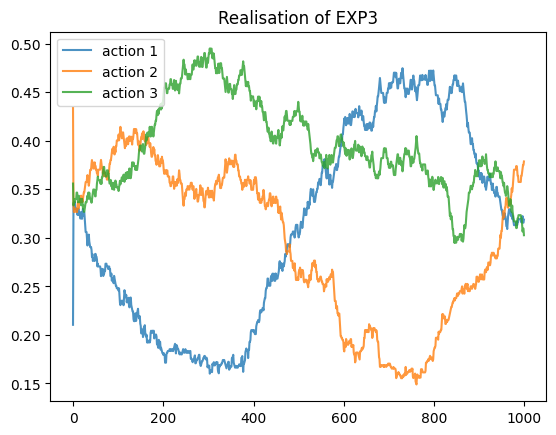

In [26]:
plt.plot(ps, label=['action 1', 'action 2', 'action 3'], alpha=0.8)
plt.legend()
plt.title('Realisation of EXP3')
plt.show()

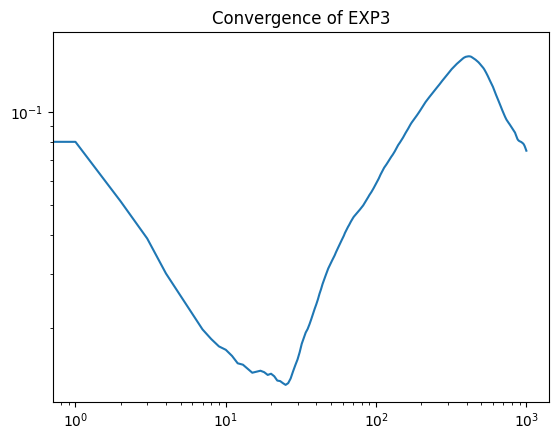

In [27]:
p_ = np.array([np.mean(ps[:i, :], axis=0) for i in range(1, ps.shape[0])])

plt.loglog(np.array([np.linalg.norm(p - np.array([1/3, 1/3, 1/3])) for p in p_]))
plt.title('Convergence of EXP3')
plt.show()

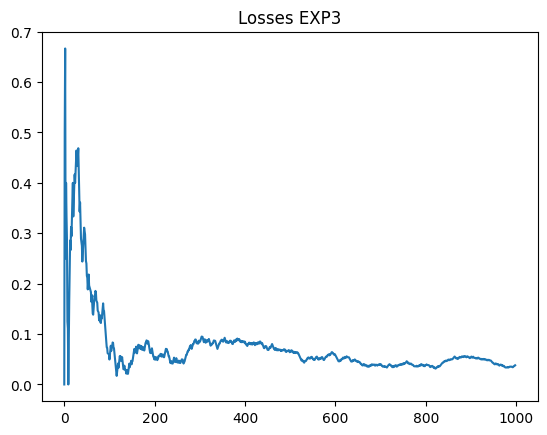

In [28]:
losses_ = np.array([np.mean(losses[:i]) for i in range(1, losses.shape[0])])

plt.plot(losses_)
plt.title('Losses EXP3')
plt.show()